l, r : 0, 499
norm_const : 8.365080458401831e-35
norm_const_est : 8.381371774354269e-35
beta : 8.387722140577835e-35
10.0


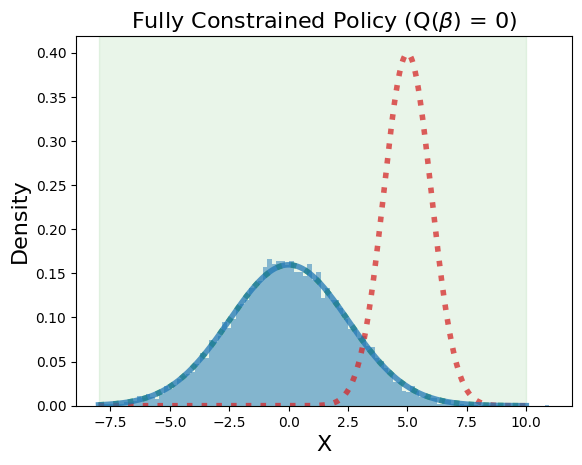

l, r : 167, 499
norm_const : 6.368164012703257e-11
norm_const_est : 6.359610395165547e-11
beta : 7.934402982580055e-11
-2.012024048096192


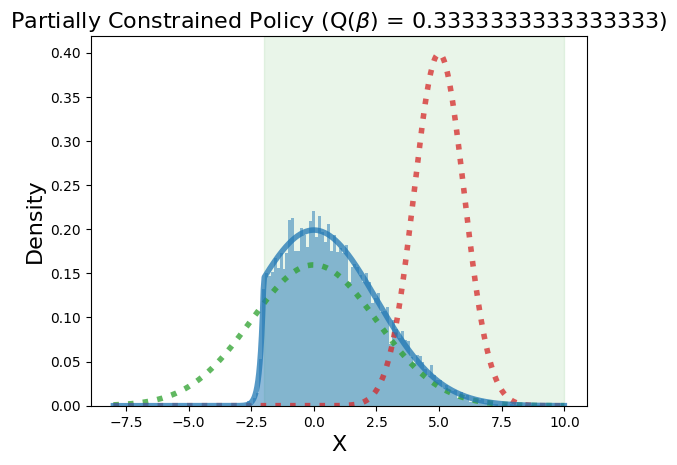

l, r : 250, 499
norm_const : 0.0003448121227269835
norm_const_est : 0.0003467869245468607
beta : 0.0009109397708537446
0.9819639278557126


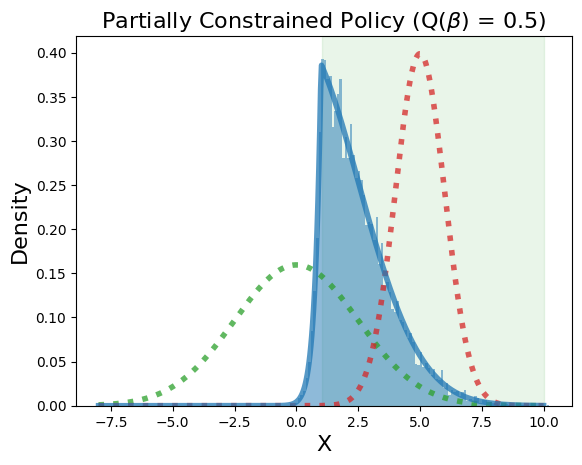

l, r : 312, 461
norm_const : 0.1597142102333862
norm_const_est : 0.16019120751267477
beta : 1.241606439394976
4.589178356713427


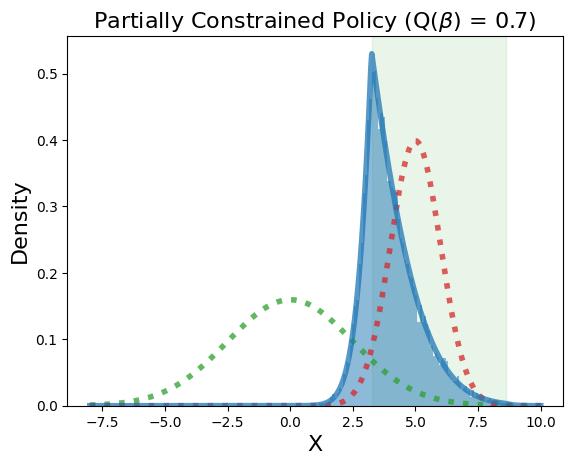

l, r : 337, 436
norm_const : 0.5248394851581822
norm_const_est : 0.5255545159632211
beta : 6.849314816274717
6.392785571142285


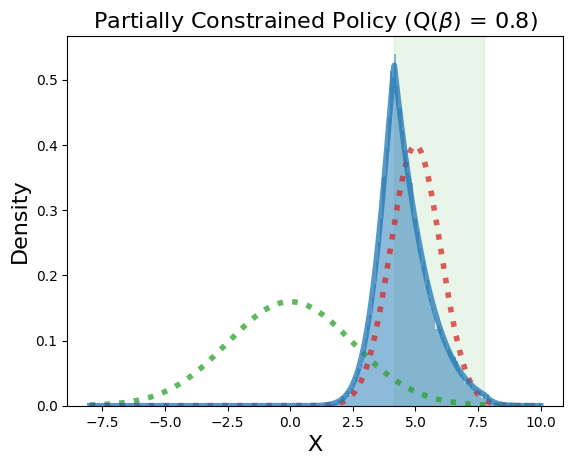

l, r : 362, 411
norm_const : 0.906398717228296
norm_const_est : 0.9075656572521399
beta : 19.126820808822558
8.196392785571142


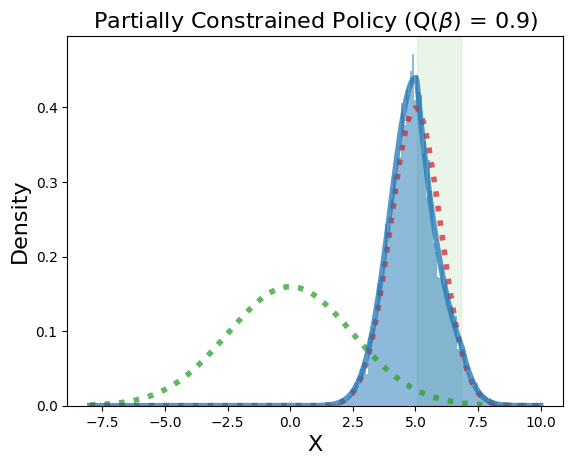

norm_const : 0.9979997398786288
norm_const_est : 1.0
beta : inf
-4


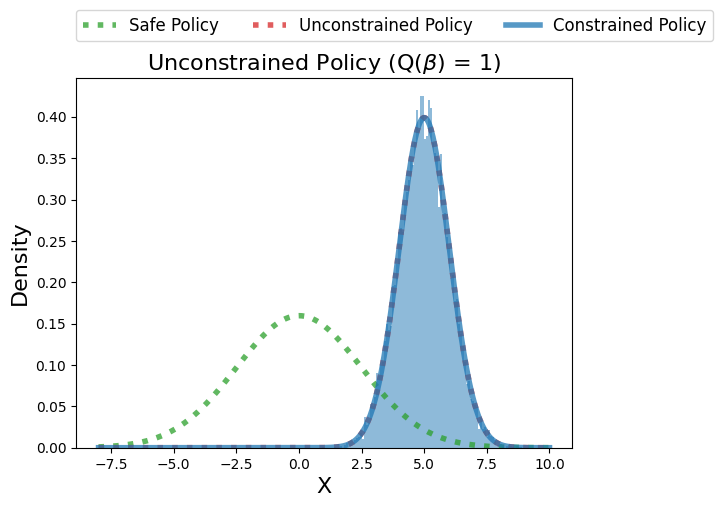

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, poisson, gamma, beta, uniform
import sys


x_values = np.linspace(-8, 10, 500) # For plotting the curve
    
m0 = 0
s0 = 2.5
pdf0_values = norm.pdf(x_values, loc=m0, scale=s0)
def pdf0(x):
    return norm.pdf(x, loc=m0, scale=s0)

m1 = 5
s1 = 1
pdf1_values = norm.pdf(x_values, loc=m1, scale=s1)
def pdf1(x):
    return norm.pdf(x, loc=m1, scale=s1)

lik_ratios = pdf1_values / pdf0_values
# beta_quantiles = np.linspace(0, 1, 5)
beta_quantiles = [0, 1/3, 0.5, 0.7, 0.8, 0.9, 1]
betas = [np.quantile(lik_ratios, q) for q in beta_quantiles]
betas[-1] = np.inf

betas = betas
beta_quantiles = beta_quantiles

n_target = 10000


# print(f'betas : {betas}')

for i, beta in enumerate(betas):
    
    pdf1_constrained_values = np.where(lik_ratios < beta, pdf1_values, beta*pdf0_values)
    x_constraint_solution_ = np.where(lik_ratios < beta, True, False)
    
    if np.sum(x_constraint_solution_) == len(x_constraint_solution_):
        ## If True everywhere:
        idx_x_left = -1
        idx_x_right = -1
    else:
        idx_x_left = np.argmin(x_constraint_solution_)
    
        idx_x_right = x_constraint_solution_.size - np.argmin(x_constraint_solution_[::-1]) - 1 
        print(f'l, r : {idx_x_left}, {idx_x_right}')

    
    x_constraint_solution = x_values[np.sum(x_constraint_solution_)-1]
    if i == len(betas)-1:
        x_constraint_solution = -4


    # if (beta_quantiles[i] <= 0.7):
    # norm_const_est
    # weight_else = 0
    norm_const_est_vals = []
    if (beta <= 0.7):
        ## Rejection sampling from safe dist
        # n_proposal = 10000
        accepted_samples = []
        # for j in range(n_proposal):
        while (len(accepted_samples) < n_target):
            u = uniform.rvs()
            safe_sample = norm.rvs(loc=m0, scale=s0)
            # if (u < pdf1(safe_samples[j])/(beta * pdf0(safe_samples[j]))):
            # print(pdf1(safe_sample))
            scaled_ratio = pdf1(safe_sample)/(beta * pdf0(safe_sample))
            if scaled_ratio < 1:
                norm_const_est_vals.append(pdf1(safe_sample)/pdf0(safe_sample))
                # norm_const_est_vals.append(pdf1(safe_sample))
            else:
                norm_const_est_vals.append(beta)
            if (u < scaled_ratio):
                accepted_samples.append(safe_sample)
            # else:
            #     print("rejected")
                # print('accepted')
        # print(f"norm_const_est_vals : {weight_if}")
        # print(f"norm_const_est_vals : {weight_else}")
        norm_const_est = np.mean(norm_const_est_vals)
        
    else:
        # Rejection sampling from unconst dist
        # n_proposal = 10000
        # unconstrained_samples = norm.rvs(loc=m1, scale=s1, size=n_proposal)
        accepted_samples = []
        # for j in range(n_proposal):
        while (len(accepted_samples) < n_target):
            u = uniform.rvs()
            unconstrained_sample = norm.rvs(loc=m1, scale=s1)
            # if (u < pdf0(unconstrained_samples[j]) * beta / pdf1(unconstrained_samples[j])):
            scaled_ratio = pdf0(unconstrained_sample) * beta / pdf1(unconstrained_sample)
            # print(scaled_ratio)
            if scaled_ratio >= 1:
                norm_const_est_vals.append(1)
            else:
                norm_const_est_vals.append(np.clip(pdf0(unconstrained_sample) * beta / pdf1(unconstrained_sample), a_min=None, a_max=99999999))
                # norm_const_est_vals.append(beta)
                
            if (u < scaled_ratio):
                accepted_samples.append(unconstrained_sample)
                # print('accepted')
            # else:
            #     print("rejected")
        
        norm_const_est = np.mean(norm_const_est_vals)
    # if (len(norm_const_est_vals) > 0):
    #     # print(norm_const_est_vals)
    #     norm_const_est = np.mean(norm_const_est_vals)
    # else:
    #     norm_const_est = 1

    # print(f'pdf1_constrained_values : {pdf1_constrained_values}')
    # pdf1_constrained_values_normalized = pdf1_constrained_values 
    norm_const = (np.sum(pdf1_constrained_values) * (np.max(x_values) - np.min(x_values)) / len(x_values))
    print(f"norm_const : {norm_const}")
    # pdf1_constrained_values_normalized = pdf1_constrained_values / norm_const
    pdf1_constrained_values_normalized = pdf1_constrained_values / norm_const_est
    print(f"norm_const_est : {norm_const_est}")
    # print(pdf1_constrained_values)

    print(f'beta : {beta}')

    if (beta < max(betas)):
        plt.axvspan(xmin=x_values[idx_x_left], xmax=x_values[idx_x_right], alpha = 0.1, color='C2')



    plt.hist(np.array(accepted_samples), bins=100, density=True, alpha = 0.5)
    
    plt.plot(x_values, pdf0_values, label='Safe Policy', color='C2', linestyle=':', alpha = 0.75, linewidth=4)
    plt.plot(x_values, pdf1_values, label='Unconstrained Policy', color='C3', linestyle=':', alpha = 0.75, linewidth=4)
    plt.plot(x_values, pdf1_constrained_values_normalized, label='Constrained Policy', color='C0', alpha = 0.75, linewidth=4)

    if beta == np.inf:
        plt.title(rf'Unconstrained Policy (Q($\beta$) = {beta_quantiles[i]})', fontsize=16)
    elif beta == min(betas):
        plt.title(rf'Fully Constrained Policy (Q($\beta$) = {beta_quantiles[i]})', fontsize=16)
    else:
        plt.title(rf'Partially Constrained Policy (Q($\beta$) = {beta_quantiles[i]})', fontsize=16)

    print(x_constraint_solution)
    # plt.axvline(x=x_constraint_solution, color='black', linestyle=':', label=r'x s.t. p_t(x) / p_{safe} == $\lambda$')
    if i == len(betas)-1:
        plt.legend(loc=[0, 1.1], ncols=4, fontsize=12)
    plt.xlabel('X', fontsize=16)
    plt.ylabel('Density', fontsize=16)
    plt.savefig(f'./constrained_ex_beta{beta}.png')
    plt.show()
    





In [14]:
samples = norm.rvs(loc=m0, scale=s0, size=10)
samples

array([-0.61923366,  0.8485605 ,  3.47756425, -4.00116812, -5.85162943,
       -6.46603351, -0.61813508, -2.97710307,  4.30933523, -1.11058081])

In [102]:
a = [1, 2, 3]
[*a]

[1, 2, 3]

In [36]:
np.linspace(0,1, 5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [29]:
import sys
print(sys.float_info.min)

2.2250738585072014e-308


In [12]:
data = pd.read_json(f'/data/bucket/prinstea/llome/parent_output_20250901_temp1/smaller_pythia/smaller_pythia_sft_init_r0/gens_init_likelihood_100sample_2iter.jsonl', lines = True)
data


,trajectory_id,particle,score,input_particle,input_score,seed_score,in_dataset,iter,loglikelihood,num_particles_generated,hamming_distance
0,0,"[12, 31, 2, 4, 15, 11, 14, 15, 12, 31, 11, 10,...",-0.016000,None,NaN,-0.016,True,0,NaN,0,NaN
1,0,"[12, 31, 2, 4, 15, 11, 14, 11, 12, 31, 11, 10,...",-0.015625,"[12, 31, 2, 4, 15, 11, 14, 15, 12, 31, 11, 10,...",-0.016000,-0.016,False,1,-0.016208,1,0.06250
2,0,"[12, 31, 2, 4, 15, 11, 14, 9, 12, 31, 11, 10, ...",-0.023438,"[12, 31, 2, 4, 15, 11, 14, 15, 12, 31, 11, 10,...",-0.016000,-0.016,True,1,-0.022005,4,0.06250
3,0,"[12, 31, 2, 4, 15, 11, 1, 15, 11, 11, 15, 10, ...",NaN,"[12, 31, 2, 4, 15, 11, 14, 11, 12, 31, 11, 10,...",-0.015625,-0.016,False,2,-0.196686,1001,0.15625
4,0,"[12, 31, 2, 4, 15, 11, 21, 15, 12, 31, 11, 10,...",-0.015625,"[12, 31, 2, 4, 15, 11, 14, 11, 12, 31, 11, 10,...",-0.015625,-0.016,True,2,-0.009864,1002,0.06250
...,...,...,...,...,...,...,...,...,...,...,...
2107,91,"[12, 29, 2, 10, 31, 12, 31, 14, 11, 13, 15, 11...",NaN,"[12, 31, 2, 4, 15, 11, 14, 15, 12, 31, 11, 10,...",-0.016000,-0.016,False,2,-1.089152,1919,0.65625
2108,93,"[12, 31, 2, 6, 15, 7, 15, 15, 12, 31, 11, 10, ...",NaN,"[12, 31, 2, 4, 15, 10, 14, 15, 12, 31, 11, 10,...",-0.016000,-0.016,False,2,-0.899963,1933,0.56250
2109,94,"[12, 31, 7, 3, 15, 11, 14, 11, 12, 14, 16, 12,...",NaN,"[12, 31, 2, 4, 15, 11, 14, 15, 12, 31, 11, 10,...",-0.016000,-0.016,False,1,-1.207420,943,0.78125
2110,98,"[12, 31, 2, 4, 15, 11, 14, 15, 12, 31, 11, 10,...",-0.015625,"[12, 31, 2, 4, 15, 11, 14, 15, 12, 31, 11, 10,...",-0.016000,-0.016,False,1,-0.234384,982,0.09375


In [63]:
## Pre-training initialization:
import numpy as np
import pandas as pd

for i in range(0, 5):
    # data = pd.read_json(f'/data/bucket/prinstea/llome/parent_output_20250901_temp1/smaller_pythia/smaller_pythia_sft_init_r{i}/gens_init_likelihood_100sample_2iter.jsonl', lines = True)
    data = pd.read_json(f'/data/bucket/prinstea/llome/parent_output_20250901_temp1/smaller_pythia/smaller_pythia_sft_init_r{i}/gens_init_likelihood_100sample_2iter_temp1.0_10seqs.jsonl', lines = True)
    # num_inf = len(data[data['score']==np.inf])
    num_infeasible = len(data[data['score'].isna()]) + len(data[data['score']==np.inf])
    num_in_training = len(data[data['in_dataset']==True])
    
    n = len(data)
    print(f'r{i}, n : {n}, frac infeasible  : {num_infeasible/n}')
    print(f'r{i}, n : {n}, frac in training : {num_in_training/n} \n')


r0, n : 1077, frac infeasible  : 0.27669452181987003
r0, n : 1077, frac in training : 0.3370473537604457 

r1, n : 1880, frac infeasible  : 0.20425531914893616
r1, n : 1880, frac in training : 0.375 

r2, n : 2046, frac infeasible  : 0.0855327468230694
r2, n : 2046, frac in training : 0.3998044965786901 

r3, n : 2076, frac infeasible  : 0.046242774566473986
r3, n : 2076, frac in training : 0.4094412331406551 

r4, n : 2089, frac infeasible  : 0.02584968884633796
r4, n : 2089, frac in training : 0.5543322163714696 



In [25]:
 import pandas as pd

# Create a sample DataFrame
data = {'col1': range(1), 'col2': [f'val_{i}' for i in range(1)]}
df = pd.DataFrame(data)

# Set a random_state for reproducibility
# This ensures that the same random split is generated every time the code is run
random_seed = 42

# Define the fraction for the first part (e.g., 80% for training)
train_frac = 0.500001

# Create the training set by sampling the specified fraction
train_df = df.sample(frac=train_frac, random_state=random_seed)

# Create the testing set by dropping the rows that are in the training set
test_df = df.drop(train_df.index)

print("Training DataFrame shape:", train_df.shape)
print("Testing DataFrame shape:", test_df.shape)



Training DataFrame shape: (1, 2)
Testing DataFrame shape: (0, 2)


In [62]:

# data = pd.read_json('/data/bucket/prinstea/llome/parent_output/smaller_pythia/smaller_pythia_sft_r6/gens_likelihood_1sample_10iter_temp1.0_10seqs.jsonl', lines=True)
import pandas as pd
import numpy as np

## Extrapolation:
for i in range(25):
    # data = pd.read_json(f'/data/bucket/prinstea/llome/parent_output_20250901_temp1/smaller_pythia/smaller_pythia_sft_r{i}_20250901/gens_likelihood_10sample_10iter.jsonl', lines = True)
    # data = pd.read_json(f'/data/bucket/prinstea/llome/parent_output_20250904_moreSFT_100s/smaller_pythia/smaller_pythia_sft_r{i}/gens_likelihood_100sample_1iter.jsonl', lines=True)
    # data = pd.read_json(f'/data/bucket/prinstea/llome/parent_output_20250904_moreSFT_100s/smaller_pythia/smaller_pythia_sft_r{i}/gens_likelihood_25sample_1iter.jsonl', lines=True)
    data = pd.read_json(f'/data/bucket/prinstea/llome/parent_output_20250904_moreSFT_10s/smaller_pythia/smaller_pythia_sft_r{i}/gens_likelihood_10sample_1iter.jsonl', lines=True)
    
    # num_inf = len(data[data['score']==np.inf])
    num_infeasible = len(data[data['score'].isna()]) + len(data[data['score']==np.inf])
    num_in_training = len(data[data['in_dataset']==True])
    # display(data.iloc[0:2,:])
    
    n = len(data)
    print(f'r{i}, n : {n}, frac infeasible  : {num_infeasible/n}')
    print(f'r{i}, n : {n}, frac in training : {num_in_training/n} \n')

# data


r0, n : 75, frac infeasible  : 0.02666666666666667
r0, n : 75, frac in training : 0.10666666666666667 

r1, n : 99, frac infeasible  : 0.2222222222222222
r1, n : 99, frac in training : 0.04040404040404041 

r2, n : 101, frac infeasible  : 0.1782178217821782
r2, n : 101, frac in training : 0.09900990099009901 

r3, n : 94, frac infeasible  : 0.0851063829787234
r3, n : 94, frac in training : 0.10638297872340426 

r4, n : 93, frac infeasible  : 0.053763440860215055
r4, n : 93, frac in training : 0.11827956989247312 

r5, n : 99, frac infeasible  : 0.04040404040404041
r5, n : 99, frac in training : 0.13131313131313133 

r6, n : 87, frac infeasible  : 0.06896551724137931
r6, n : 87, frac in training : 0.16091954022988506 

r7, n : 99, frac infeasible  : 0.06060606060606061
r7, n : 99, frac in training : 0.10101010101010101 

r8, n : 94, frac infeasible  : 0.06382978723404255
r8, n : 94, frac in training : 0.1276595744680851 

r9, n : 77, frac infeasible  : 0.025974025974025976
r9, n : 77, f

/tmp/ipykernel_2823650/1252470707.py:10: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data = pd.read_json(f'/data/bucket/prinstea/llome/parent_output_20250904_moreSFT_10s/smaller_pythia/smaller_pythia_sft_r{i}/gens_likelihood_10sample_1iter.jsonl', lines=True)


ValueError: Expected object or value

(2, 3)

In [3]:
# data = pd.read_json('/data/bucket/prinstea/llome/parent_output/smaller_pythia/smaller_pythia_gpt/gens_init_likelihood_1000sample_10iter.jsonl', lines=True)
# data = pd.read_json('/data/bucket/prinstea/llome/parent_output/smaller_pythia/smaller_pythia_gpt/gens_init_likelihood_1000sample_10iter_temp1.0_10seqs.jsonl', lines=True)
# data = pd.read_json('/data/bucket/prinstea/llome/parent_output/smaller_pythia/gpt_unif_dense_neighborhood_pairs_xthres0.25_maxinfs0.1_30nn.jsonl', lines=True)
# data
data = pd.read_json('/data/bucket/prinstea/llome/parent_output/smaller_pythia/smaller_pythia_sft_r1/gens_likelihood_100sample_10iter_temp1.0_10seqs.jsonl', lines=True)
# num_inf = len(data[data['score'].isna()]) + len(data[data['score']==np.inf])
    
n = len(data)
print(n)
# print(f'r{i}, frac infeasible : {num_inf/n}')
# data["in_dataset"].sum()
print(f'Frac particles in training data : {len(data[data["in_dataset"]==True]) / n}')
data

6
Frac particles in training data : 1.0


,trajectory_id,particle,score,input_particle,input_score,seed_score,in_dataset,iter,loglikelihood,num_particles_generated,hamming_distance
0,0,"[12, 31, 2, 4, 15, 6, 14, 15, 12, 31, 11, 10, ...",-0.062,NaN,NaN,-0.062,True,0,NaN,0,NaN
1,1,"[12, 31, 2, 4, 15, 6, 14, 15, 12, 31, 11, 10, ...",-0.062,NaN,NaN,-0.062,True,0,NaN,0,NaN
2,2,"[12, 31, 2, 4, 15, 6, 14, 15, 12, 31, 11, 10, ...",-0.062,NaN,NaN,-0.062,True,0,NaN,0,NaN
3,3,"[12, 31, 2, 4, 15, 6, 14, 15, 12, 31, 11, 10, ...",-0.062,NaN,NaN,-0.062,True,0,NaN,0,NaN
4,4,"[12, 31, 2, 4, 15, 6, 14, 15, 12, 31, 11, 10, ...",-0.062,NaN,NaN,-0.062,True,0,NaN,0,NaN
5,5,"[12, 31, 2, 4, 15, 6, 14, 15, 12, 31, 11, 10, ...",-0.062,NaN,NaN,-0.062,True,0,NaN,0,NaN


In [44]:
import numpy as np
a = np.array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.9999757 , 0.00268334,
       0.9996437 , 0.9984262 , 0.9999994 , 0.96831906, 0.9999993 ,
       0.9276532 , 0.9999999 , 0.9457009 , 1.        , 0.9989404 ,
       1.        , 0.7990209 , 1.        , 0.9945381 , 0.99999654,
       0.9836394 , 1.        , 0.99783605, 1.        , 0.939762  ,
       0.99999964, 0.999624  , 1.        , 0.9961732 , 1.        ,
       0.9590705 , 1.        , 0.9468553 , 0.99999976, 0.99964845,
       0.99999964, 0.9756631 , 0.9999999 , 0.9997564 , 1.        ,
       0.9998136 , 0.99999976, 0.9795368 , 0.99999845, 0.8060646 ,
       0.99999905, 0.99828523, 0.999997  , 0.9507775 , 0.99999905,
       0.9964759 , 1.        , 0.98720807, 0.99999976, 0.9977544 ,
       0.9998641 , 0.9933022 , 1.        , 0.49467334, 0.99999595,
       0.8103291 , 0.9999355 , 0.9646651 , 0.9999999 , 0.99300814,
       0.9999968 , 0.82099724, 0.9999244 ])

b = np.array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.99997985, 0.00346163,
       0.9996593 , 0.99715245, 0.9999993 , 0.97442675, 0.99999917,
       0.9453344 , 0.9999999 , 0.9257733 , 1.        , 0.9991731 ,
       1.        , 0.8534383 , 1.        , 0.98922884, 0.99999654,
       0.9874391 , 1.        , 0.9980338 , 1.        , 0.94244903,
       0.9999999 , 0.9993235 , 1.        , 0.99135756, 1.        ,
       0.95656496, 1.        , 0.9656669 , 0.9999999 , 0.99915934,
       0.9999994 , 0.9750972 , 0.9999999 , 0.9995208 , 1.        ,
       0.99948394, 0.9999987 , 0.965408  , 0.9999962 , 0.8454996 ,
       0.99999905, 0.9985127 , 0.99999774, 0.9480506 , 0.99999833,
       0.98997724, 1.        , 0.9446316 , 0.9999999 , 0.9941362 ,
       0.9999126 , 0.9825868 , 1.        , 0.60311216, 0.9999974 ,
       0.90260494, 0.9999864 , 0.9594176 , 1.        , 0.9928461 ,
       0.9999989 , 0.78914386, 0.99979085])

np.where((a == 0) & (b > 0))

(array([], dtype=int64),)

In [4]:
import torch
generated_suffix = torch.empty(
    (1, 0)
)
generated_suffix.shape

torch.Size([1, 0])

In [7]:
from typing import List

def func(a : List[str]):
    return a

a = ['a', 'b']
func(a)

['a', 'b']

In [9]:
data_fp_list_str = "\\["
data_fp_list_str += 'asdf'
data_fp_list_str

'\\[asdf'